### Algoritmos Genéticos

Para los ejemplos utilizaremos el problema del viajante de comercio (TSP)

In [21]:
# definición del TSP

import random

def dist (x, y): # distancia euclídea
	return ( (x[0]-y[0])**2 + (x[1]-y[1])**2 ) ** 0.5

def globaldist (cities): # calcula la ditancia global de una solución
	acum = 0.0
	for i in range(len(cities)):
		acum += dist(cities[i-1],cities[i]) # -1 is the last element
	return acum

def nearest (c, l): # get the nearest city to c in l
	res = l[0]
	d = dist(c,l[0])
	for e in l[1:]:
		newd = dist(c,e)
		if newd < d:
			res = e
			d = newd
	return res

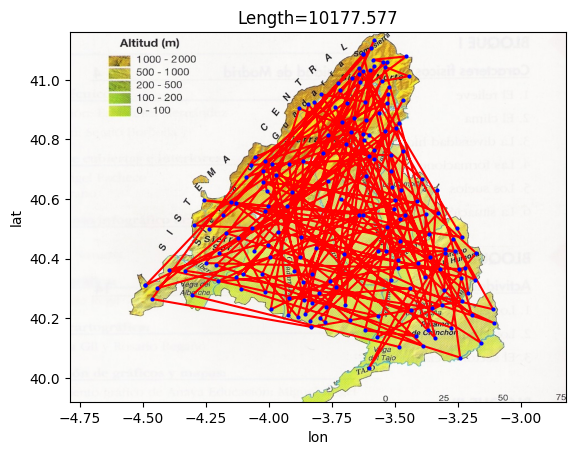

In [22]:
# Poblaciones de la Comunidad de Madrid

from madrid import *
import matplotlib.pyplot as plt
import numpy as np

def dist (x, y):
	return ( ( (x[0]-y[0])**2 + (x[1]-y[1])**2 ) ** 0.5 ) * 111.1 # km por grado

def draw (solution):
    minx, maxx = -4.79, -2.82
    miny, maxy = 39.92, 41.16
    margx = 0.05
    margy = 0.1

    plt.ion()
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_xlabel('lon')
    axes.set_ylabel('lat')
    axes.set_xlim(minx, maxx)
    axes.set_ylim(miny, maxy)
    img = plt.imread("media/madrid.jpg")
    plt.imshow(img, extent=[minx-margx,maxx+margx,miny-margy,maxy+margy], aspect='auto')

    bucle = solution + [solution[0]] # añade al final la vuelta a la primera
    c = np.array(bucle)
    x = c[:,1]
    y = c[:,0]

    l1, = axes.plot(x, y,'r')
    pl2, = axes.plot(x, y,'bo',markersize=2)
    
    s = 'Length=%5.3f' % globaldist(bucle)
    plt.title(s)

draw(cities)

### Algoritmos Genéticos

Haremos una implementación funcional, aunque sería más apropiado definir una clase

In [23]:
import random

class AG:
    def __init__ (self, alphabet, fitness_func, L, pcross, pmut, T):
        # inicializa atributos de clase (puedes añadir más cosas)
        self.alphabet = alphabet # alfabeto a utilizar
        self.finess_func = fitness_func # función de fitness
        self.L = L # en permutación debe ser igual a len(alphabet)
        self.pcross = pcross # probabilidad de cruce
        self.pmut = pmut # probabilidad de mutación
        self.T = T # parámetro T para selección por torneo

    def sort_pop (self, pop, reverse=False): # ordena población por firness (reverse=True si queremos maximizar)
        pop_to_fit = {tuple(p):self.finess_func(p) for p in pop}.items()
        pop_to_fit = sorted(pop_to_fit, key=lambda p: p[1])
        return [list(row) for row in zip(*pop_to_fit)]


    def select (self, pop, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
        selected_pop = random.choices(pop, k=T)
        # La seleccion de los participantes en el torneo se hace con reemplazamiento.
        return max(selected_pop, key=self.finess_func)

    def evolve (self, pop, ngen=100, trace=0, elitism=False):
        N = len(pop)
        L = len(pop[0])

        for i in range(ngen): # para cada generación
            newpop = []
            f, pop = self.sort_pop(pop, self.finess_func) # ordena por fitness
            best = pop[0]
            bestf = f[0]
            if elitism: # mantiene los dos mejores
                newpop.append(pop[0])
                newpop.append(pop[1])
            while len(newpop) < N:
                i1 = self.select()
                i2 = self.select()
                i1, i2 = self.crossover(i1, i2)
                i1 = self.mutate(i1)
                i2 = self.mutate(i2)
                newpop.append(i1)
                newpop.append(i2)
            pop = newpop
            if trace != 0:
                if i%trace == 0:
                    print(f"{bestf:.4f}")
        print(f"\nFitness óptimo: {bestf:.3f}")
        print("Mejor individuo", best)
        f, pop = self.sort_pop(pop, self.finess_func, False)
        return pop

In [26]:
class AG_perm (AG):
    def __init__(self, alphabet, fitness_func, L, pcross, pmut, T):
        super().__init__(alphabet, fitness_func, L, pcross, pmut, T)

    def create (self, N=100):
        pop =  [self.alphabet.copy()] * N
        for p in pop:
            random.shuffle(p)

        return pop
        
        

    def crossover (self, ind1, ind2): # order crossover (OX1)
        if random.random() > self.pcross:
            return ind1, ind2

        def gen_child(ind1, ind2):
            dif_set = set(ind2) - set(ind1[a:b+1]) # Conjunto de genes del padre 2 destinados al descendiente
            dif_list_ind_2 = [gen for gen in ind2 if gen in dif_set] # Usamos es set para generar la lista (Respetando orden)
            child = dif_list_ind_2[:a] + ind1[a:b+1] + dif_list_ind_2[a:] # Combinacion de los genes
            return child

        L = len(ind1)
        a, b = sorted(random.sample(range(L)))

        child1 = gen_child(ind1, ind2)
        child2 = gen_child(ind2, ind1)

        return child1, child2
        

    def mutate (self, ind:list[int]): # la mutación consistirá en intercambiar elementos
        if random.random() < self.pmut:
            ind = ind.copy()
            a, b = random.sample(range(self.L))
            ind[a], ind[b] = ind[b], ind[a]

In [28]:
ag_cities_solver = AG_perm(list(range(len(cities))), globaldist, len(cities[0]), 0.7, 0.01, 3)
pop = ag_cities_solver.create()
ag_cities_solver.evolve(pop, trace=True)

TypeError: 'int' object is not subscriptable

### Vamos con el TSP

Creamos la población

In [ ]:
def fitness_TSP (ind):
    return 1 / (1 + globaldist(ind))

g = AG_perm(cities, fitness_TSP, 0.7, 0.01, L=len(cities), T=2)
pop = g.create(cities)

### Evolucionamos y pintamos resultados

In [ ]:
pop = g.evolve(pop, ngen=1000, trace=100)
draw(pop[0])

Si no llega a una solución suficientemente buena. Puede ser por varios motivos:
  * Pocas generaciones. Continuar a ver.
  * pmut incorrecta: demasiado baja: convergencia muy lenta; demasiado alta: mucha aleatoriedad, la optimización no pregresa debido al ruido.
  * T incorrecto: demasiado bajo, pocas opciones a los mejores; demasiado alto: se cae en minimo local.
  * El mejor individuo se pierde: probar elitismo.
  * Hemos caído en un mínimo local: volver a empezar (multiarranque).
  * Hay otras estrategias de mutación mejores para este problema, mejorar la implementación.

1265.4403 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1257.1743 1257.1743 1257.1743 1247.5130 1247.5130 1247.2510 1247.2510 
Fitness óptimo: 1247.251
Mejor individuo [[40.54481, -3.457924], [40.53437, -3.481002], [40.50481, -3.53227], [40.54751, -3.626394], [40.54754, -3.642091], [40.42594, -3.565464], [40.42553, -3.536694], [40.39701, -3.487864], [40.4589, -3.479771], [40.48166, -3.364136], [40.54861, -3.377597], [40.59229, -3.41205], [40.6665, -3.392131], [40.63099, -3.332983], [40.5542, -3.328439], [40.50191, -3.254799], [40.47216, -3.233114], [40.46549, -3.268585], [40.43228, -3.298869], [40.36622, -3.321994], [40.33815, -3.380982], [40.38393, -3.409393], [40.40473, -3.360132], [40.41972, -3.298921], [40.42489, -3.262723], [40.41869, -3.177605], [40.3292, -3.181895], [40.36943, -3.221704], [40.36552, -3.243183], [40.33669, -3.235551], [40.29548, -3.303884], [40.23453, -3.352198], [40.24457, -3.314466], [40.

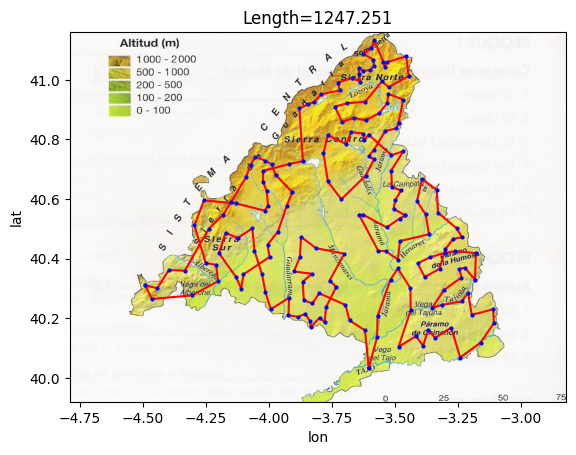

In [ ]:
# ejemplo; debes superar al menos esta solución:
pop = g.evolve(pop, ngen=10000, trace=500, T=12)
draw(pop[0])

In [ ]:
# función himmelblau y himmelblau global

onlyone = False # poner a True para que la solución sea única
def himmelblau (ch):
	x = ch[0]
	y = ch[1]
	fxy = (x**2 + y - 11)**2 + (x + y**2 -7)**2
	if onlyone and (x>0 or y>0): # himmelblau modified to have only one global minimum (-3.77, -3.28)
		fxy += 0.5
	return fxy

### Comentarios finales sobre el TSP

  * Hay varias vecindades interesantes en https://dm865.github.io/assets/dm865-tsp-ls-handout.pdf
  * Para problemas grandes, el problema es que como mínimo son $O(n^2)$
  * El fitness se puede calcular en una búsqueda local con deltas, es decir, alterando la evaluación anterior teniendo en cuenta el cambio realizado, lo que hace la evaluación mucho más rápida. Por ejemplo, si una ciudad se intercambia por otra sólo hay que restar 4 valores y sumar otros 4, en lugar de recorrer la lista entera.
  * Según el teorema del no free lunch, esto hace nuestro algoritmo más específico del problema TSP.